In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time

In [2]:
    #https://raw.githubusercontent.com/ivmech/ivPID/master/PID.py
class PID:
  def __init__(self, P=0.2, I=0.0, D=0.0, current_time=None):

        self.Kp = P
        self.Ki = I
        self.Kd = D

        self.sample_time = 0.00
        self.current_time = current_time if current_time is not None else time.time()
        self.last_time = self.current_time

        self.clear()

  def clear(self):
        #Clears PID computations and coefficients
        self.SetPoint = 0.0

        self.PTerm = 0.0
        self.ITerm = 0.0
        self.DTerm = 0.0
        self.last_error = 0.0

        # Windup Guard
        self.int_error = 0.0
        self.windup_guard = 20.0

        self.output = 0.0

  def update(self, feedback_value, current_time=None):
        """Calculates PID value for given reference feedback
        .. math::
            u(t) = K_p e(t) + K_i \int_{0}^{t} e(t)dt + K_d {de}/{dt}
        .. figure:: images/pid_1.png
           :align:   center
        """
        error = self.SetPoint - feedback_value

        self.current_time = current_time if current_time is not None else time.time()
        delta_time = self.current_time - self.last_time
        delta_error = error - self.last_error

        if (delta_time >= self.sample_time):
            self.PTerm = self.Kp * error
            self.ITerm += error * delta_time

            if (self.ITerm < -self.windup_guard):
                self.ITerm = -self.windup_guard
            elif (self.ITerm > self.windup_guard):
                self.ITerm = self.windup_guard

            self.DTerm = 0.0
            if delta_time > 0:
                self.DTerm = delta_error / delta_time

            # Remember last time and last error for next calculation
            self.last_time = self.current_time
            self.last_error = error

            self.output = self.PTerm + (self.Ki * self.ITerm) + (self.Kd * self.DTerm)

  def setKp(self, proportional_gain):
        #Determines how aggressively the PID reacts to the current error with setting Proportional Gain
        self.Kp = proportional_gain

  def setKi(self, integral_gain):
        #Determines how aggressively the PID reacts to the current error with setting Integral Gain
        self.Ki = integral_gain

  def setKd(self, derivative_gain):
        #Determines how aggressively the PID reacts to the current error with setting Derivative Gain
        self.Kd = derivative_gain

  def setWindup(self, windup):
        """Integral windup, also known as integrator windup or reset windup,
        refers to the situation in a PID feedback controller where
        a large change in setpoint occurs (say a positive change)
        and the integral terms accumulates a significant error
        during the rise (windup), thus overshooting and continuing
        to increase as this accumulated error is unwound
        (offset by errors in the other direction).
        The specific problem is the excess overshooting.
        """
        self.windup_guard = windup

  def setSampleTime(self, sample_time):
        #PID that should be updated at a regular interval.
        #Based on a pre-determined sampe time, the PID decides if it should compute or return immediately.
        
        self.sample_time = sample_time

#Stanford 

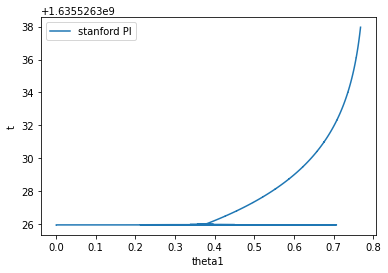

Stanford inverse: 
 Theta1 =  0.7853981633974483 rad
 Theta2 = 0.0 rad
 Extension=  0.41421356237309515 m

Stanford forward: 
 X =  1.0000000000000002 m
 Y = 1.0 m
 Z=  1.0 m



In [10]:
#inverse codes used from repository
def stanford(endeffector_position,lengthsoflinks,des):
    #PI control
    P=0.9
    I=0.5
    pi1=PID(P,I)
    pi2=PID(P,I)
    pi3=PID(P,I)

    #innverse kinematics 
    theta1 = np.arctan(endeffector_position[1]/endeffector_position[0])
    r = np.sqrt(endeffector_position[0]**2 + endeffector_position[1]**2)
    s = endeffector_position[2] - lengthsoflinks[0]
    theta2 = np.arctan(s/r)
    d3 = np.sqrt(r**2 + s**2) - lengthsoflinks[1]

    #innverse kinematics des
    theta1_des = np.arctan(des[1]/des[0])
    r_des = np.sqrt(des[0]**2 + des[1]**2)
    s_des = des[2] - lengthsoflinks[0]
    theta2_des = np.arctan(s_des/r_des)
    d3_des = np.sqrt(r_des**2 + s_des**2) - lengthsoflinks[1]

    pi1.SetPoint=(theta1_des)   
    pi1.setSampleTime(0.001)
    pi1.update(theta1)
    theta=pi1.output
    TH1=[]
    time=[]
    while int((pi1.SetPoint-pi1.output)*180/1.57)!=1:
      theta = pi1.output
      TH1.append(theta)
      time.append(pi1.current_time)
      pi1.update(theta)
      #print(pi1.last_error)
    
    plt.plot(TH1,time, label='stanford PI')
    plt.legend()
    plt.xlabel("theta1")
    plt.ylabel("t")
    plt.show()

    print("Stanford inverse: \n", "Theta1 = ", theta1, "rad\n Theta2 =", theta2,"rad\n Extension= ", d3, "m\n")
    #return [theta1,theta2,extension]
    #forward kinematics
    x=(lengthsoflinks[1]+d3)*math.cos(theta1)*math.cos(theta2)
    y=(lengthsoflinks[1]+d3)*math.sin(theta1)*math.cos(theta2)
    z=lengthsoflinks[0]+(lengthsoflinks[1]+d3)*math.sin(theta2)
    print("Stanford forward: \n", "X = ", x, "m\n Y =", y,"m\n Z= ", z, "m\n")
  

stanford([1,1,1],[1,1,1],[1.1,1.1,2])

#Scara

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


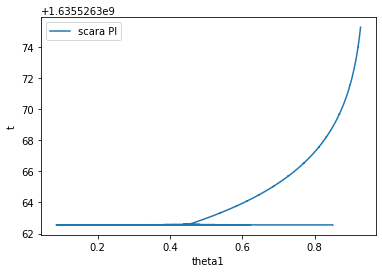

Scara Inverse: 
 Theta1 =  0.0 rad
 Theta2 = 1.5707963267948966 rad
 Extension:  0 m

Scara Inverse des: 
 Theta1 =  0.9446469267224759 rad
 Theta2 = 1.0529614951625175 rad
 Extension:  -1 m

Scara forward: 
 X =  1.0 m
 Y = 1.0 m
 Z=  1 m



In [11]:
#inverse codes used from repository

def scara(endeffector_position,lengthsoflinks,des):
    #PI control
    P=0.9
    I=0.5
    pi1=PID(P,I)
    pi2=PID(P,I)
    pi3=PID(P,I)

    #inverse Kinematics
    r = abs((endeffector_position[0]**2+endeffector_position[1]**2-lengthsoflinks[0]**2-lengthsoflinks[1]**2)/(2*lengthsoflinks[0]*lengthsoflinks[1]))
    theta2 = np.arctan(np.sqrt(abs(1-r**2))/r)
    theta1 = np.arctan(endeffector_position[1]/endeffector_position[0]) - np.arctan((lengthsoflinks[1]*np.sin(theta2))/(lengthsoflinks[0]+lengthsoflinks[1]*np.cos(theta2)))
    d3 = lengthsoflinks[0]-endeffector_position[2]

    #inverse Kinematics des
    r = abs((des[0]**2+des[1]**2-lengthsoflinks[0]**2-lengthsoflinks[1]**2)/(2*lengthsoflinks[0]*lengthsoflinks[1]))
    theta2_des = np.arctan(np.sqrt(abs(1-r**2))/r)
    theta1_des = np.arctan(des[1]/des[0]) - np.arctan((lengthsoflinks[1]*np.sin(theta2_des))/(lengthsoflinks[0]+lengthsoflinks[1]*np.cos(theta2_des)))
    d3_des = lengthsoflinks[0]-des[2]

    pi1.SetPoint=(theta1_des)   
    pi1.setSampleTime(0.001)
    pi1.update(theta1)
    theta=pi1.output
    TH1=[]
    time=[]
    while int((pi1.SetPoint-pi1.output)*180/1.57)!=1:
      theta = pi1.output
      TH1.append(theta)
      time.append(pi1.current_time)
      pi1.update(theta)
      #print(pi1.last_error)
    
    plt.plot(TH1,time, label='scara PI')
    plt.legend()
    plt.xlabel("theta1")
    plt.ylabel("t")
    plt.show()

    
    # converting from radians to degrees
    print("Scara Inverse: \n", "Theta1 = ", theta1, "rad\n Theta2 =", theta2,"rad\n Extension: ", d3, "m\n")
    #return [theta1,theta2,Extension]
    print("Scara Inverse des: \n", "Theta1 = ", theta1_des, "rad\n Theta2 =", theta2_des,"rad\n Extension: ", d3_des, "m\n")
    #return [theta1,theta2,Extension]

    #forward kinematics
    x=lengthsoflinks[0]*math.cos(theta1)+lengthsoflinks[1]*math.cos(theta1+theta2)
    y=lengthsoflinks[0]*math.sin(theta1)+lengthsoflinks[1]*math.sin(theta1+theta2)
    z=lengthsoflinks[2]-d3
    print("Scara forward: \n", "X = ", x, "m\n Y =", y,"m\n Z= ", z, "m\n")
  
scara([1,1,1],[1,1,1],[0.1,1,2])

#Puma

puma Inverse: 
 Theta1 =  0.7853981633974483 rad
 Theta2 = 0.7853981633974483 rad
 Theta3:  -1.5707963267948966 rad

puma Inverse: 
 Theta1 =  0.7853981633974483 rad
 Theta2 = 0.9619633321486626 rad
 Theta3:  -0.7812981174487245 rad



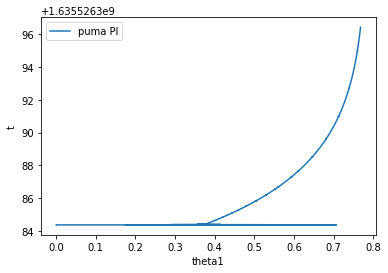

puma forward: 
 X =  1.0000000000000002 m
 Y = 1.0 m
 Z=  1.0 m



In [12]:
#inverse codes used from repository

def puma(endeffector_position,lengthsoflinks,des):
    #PI control
    P=0.9
    I=0.5
    pi1=PID(P,I)
    pi2=PID(P,I)
    pi3=PID(P,I)

    #Inverse kinematics
    theta1 = math.atan2(endeffector_position[1],endeffector_position[0])
    D = (endeffector_position[0]**2+endeffector_position[1]**2+(endeffector_position[2]-lengthsoflinks[0])**2-lengthsoflinks[1]**2-lengthsoflinks[2]**2)/(2*lengthsoflinks[1]*lengthsoflinks[2])
    if D>=1 or D<=-1:
      print("singular configuration")
      if D>1 or D<-1:
          print("outside workspace")
    else:
      theta3 = math.atan2((-math.sqrt(1-D*D)),D)
      theta2 = math.atan2(endeffector_position[2]-lengthsoflinks[0],(math.sqrt(endeffector_position[0]**2+endeffector_position[1]**2)))-math.atan2((lengthsoflinks[2]*math.sin(theta3)),(lengthsoflinks[1]+lengthsoflinks[2]*math.cos(theta3)))
      print("puma Inverse: \n", "Theta1 = ", theta1, "rad\n Theta2 =", theta2,"rad\n Theta3: ", theta3, "rad\n")
      #return [theta1,theta2,theta3]

    #Inverse kinematics des
    theta1_des = math.atan2(des[1],des[0])
    D = (des[0]**2+des[1]**2+(des[2]-lengthsoflinks[0])**2-lengthsoflinks[1]**2-lengthsoflinks[2]**2)/(2*lengthsoflinks[1]*lengthsoflinks[2])
    if D>=1 or D<=-1:
      print("singular configuration")
      if D>1 or D<-1:
          print("outside workspace")
    else:
      theta3_des = math.atan2((-math.sqrt(1-D*D)),D)
      theta2_des = math.atan2(des[2]-lengthsoflinks[0],(math.sqrt(des[0]**2+des[1]**2)))-math.atan2((lengthsoflinks[2]*math.sin(theta3_des)),(lengthsoflinks[1]+lengthsoflinks[2]*math.cos(theta3_des)))
      print("puma Inverse: \n", "Theta1 = ", theta1_des, "rad\n Theta2 =", theta2_des,"rad\n Theta3: ", theta3_des, "rad\n")
      #return [theta1,theta2,theta3]

    pi1.SetPoint=(theta1_des)   
    pi1.setSampleTime(0.001)
    pi1.update(theta1)
    theta=pi1.output
    TH1=[]
    time=[]
    while int((pi1.SetPoint-pi1.output)*180/1.57)!=1:
      theta = pi1.output
      TH1.append(theta)
      time.append(pi1.current_time)
      pi1.update(theta)
      #print(pi1.last_error)
    
    plt.plot(TH1,time, label='puma PI')
    plt.legend()
    plt.xlabel("theta1")
    plt.ylabel("t")
    plt.show()


    #forward kinematics
    x=(lengthsoflinks[1]*math.cos(theta2)+lengthsoflinks[2]*math.cos(theta2+theta3))*math.cos(theta1)
    y=(lengthsoflinks[1]*math.cos(theta2)+lengthsoflinks[2]*math.cos(theta2+theta3))*math.sin(theta1)
    z=lengthsoflinks[0]+lengthsoflinks[1]*math.sin(theta2)+lengthsoflinks[2]*math.sin(theta2+theta3)
    print("puma forward: \n", "X = ", x, "m\n Y =", y,"m\n Z= ", z, "m\n")
    
puma([1,1,1],[1,1,1],[1.1,1.1,2])